<a href="https://colab.research.google.com/github/Prateek-MSDS/Kalman-Filter-Covid19-Cases-Prediction/blob/main/Kalman_Filter_Covid_Spread_WA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kalman Filter Covid19 Cases Prediction for Washington, USA



> **Team Members:** Prateek Kakkar, Aishwarya Saibewar, Swathi Kolar Ravikumar




#Introduction


In this project, we'll try to predict the spread of coronavirus for each of the infected regions by fitting a time series analysis and statistical algorithm to produce the best short term and long-term predictions. An adaptive Kalman filter would be a good approach for one-day prediction for each region as it doesn’t require historical values like a batch estimator and hence it is a recursive estimator. 

The Kalman filter is an algorithm for efficiently performing exact inference in a linear dynamic system where the state space of the latent variables is discrete and all latent and observed variables have a Gaussian distribution. With the assumption that the time series is linear and Gaussian, we will be applying the Kalman Filter to predict the covid 19 spread across US and Washington State counties.

## Data Source:

We’ll use the data set from the COVID-19 GitHub Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. This repository is updated daily and consists of daily case reports – confirmed, deaths and recovery from each country/region in the US. https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



*   The files *time_series_covid19_deaths_US.csv and time_series_covid19_confirmed_US.csv* from the above repository was then loaded into this repository for the ease of the team to work within this notebook.

 


# Import Libraries

In [ ]:
!pip install pykalman -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv
from pykalman import KalmanFilter

#Data

##Get Data From Github Repo

In [ ]:
cce_deaths_url = 'https://raw.githubusercontent.com/Prateek-MSDS/Kalman-Filter-Covid19-Cases-Prediction/main/deaths_us.csv'
deaths_us = pd.read_csv(cce_deaths_url).set_index('UID')

cce_confirmed_url = 'https://raw.githubusercontent.com/Prateek-MSDS/Kalman-Filter-Covid19-Cases-Prediction/main/confirmed_cases_us.csv'
confirmed_cases_us = pd.read_csv(cce_confirmed_url).set_index('UID')

Take a look at the two data frames

In [ ]:
deaths_us.head()

,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,...,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22
UID,,,,,,,,,,,,,,,,,,,,,
84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",...,199,199,199,199,203,204,205,208,208,208
84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",...,645,650,650,650,653,656,657,657,662,662
84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",...,94,94,94,94,94,94,94,94,94,94
84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",...,99,99,99,99,99,99,99,100,100,100
84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",...,221,221,221,221,223,227,227,227,227,227


In [ ]:
confirmed_cases_us.head()

,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,...,3/3/22,3/4/22,3/5/22,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22
UID,,,,,,,,,,,,,,,,,,,,,
84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",...,15526,15530,15530,15530,15539,15547,15555,15559,15563,15563
84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",...,55061,55079,55079,55079,55132,55135,55142,55159,55171,55171
84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",...,5447,5447,5447,5447,5451,5454,5456,5458,5461,5461
84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",...,6378,6381,6381,6381,6395,6395,6398,6400,6401,6401
84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",...,14799,14803,14803,14803,14848,14853,14856,14861,14869,14869


##Filter Datasets for Washington State

In [ ]:
# Deaths
deaths_wa = deaths_us.loc[deaths_us['Province_State'] == 'Washington' , : ]
# Confirmed Cases
confirmed_cases_wa = confirmed_cases_us.loc[confirmed_cases_us['Province_State'] == 'Washington' , : ]

##Create a Single Data Frame for Washington State with Deaths and Confirmed Cases

We will now pivot the data from the original data frame.

In [ ]:
wa_new = pd.DataFrame(columns = ['date', 'deaths', 'deaths_per_day' ,'confirmed_case','cases_per_day'])
wa_new['date'] = deaths_wa.columns[11:]
wa_new['deaths'] = list(deaths_wa.iloc[:,11:].sum(0))
wa_new['confirmed_case'] = list(confirmed_cases_wa.iloc[:,11:].sum(0))
wa_new['date']= pd.to_datetime(wa_new['date'])
wa_new['cases_per_day'] = wa_new['confirmed_case'].diff()
wa_new['deaths_per_day'] = wa_new['deaths'].diff()
wa_new = wa_new.fillna(0)

wa_new['cases_per_day'] = wa_new['cases_per_day'].astype(int)
wa_new['deaths_per_day'] = wa_new['deaths_per_day'].astype(int)
# an attempt to fix the data issues for the deaths which we later decided to not use in the Kalman filter equation.
wa_new['deaths_per_day'] = wa_new['deaths_per_day'].abs()

Take a look at the new Combined DataFrame

In [ ]:
wa_new

,date,deaths,deaths_per_day,confirmed_case,cases_per_day
0,2020-01-22,0,0,1,0
1,2020-01-23,0,0,1,0
2,2020-01-24,0,0,1,0
3,2020-01-25,0,0,1,0
4,2020-01-26,0,0,1,0
...,...,...,...,...,...
776,2022-03-08,12076,0,1432321,0
777,2022-03-09,12133,57,1434783,2462
778,2022-03-10,12133,0,1434783,0
779,2022-03-11,12183,50,1437914,3131


We only had the cummulative count of confirmed cases and deaths but not the daily cases and deaths. So, we calculated the per day counts to align the data according to our problem statement.

#Analysis

## Plot Time serires Graphs

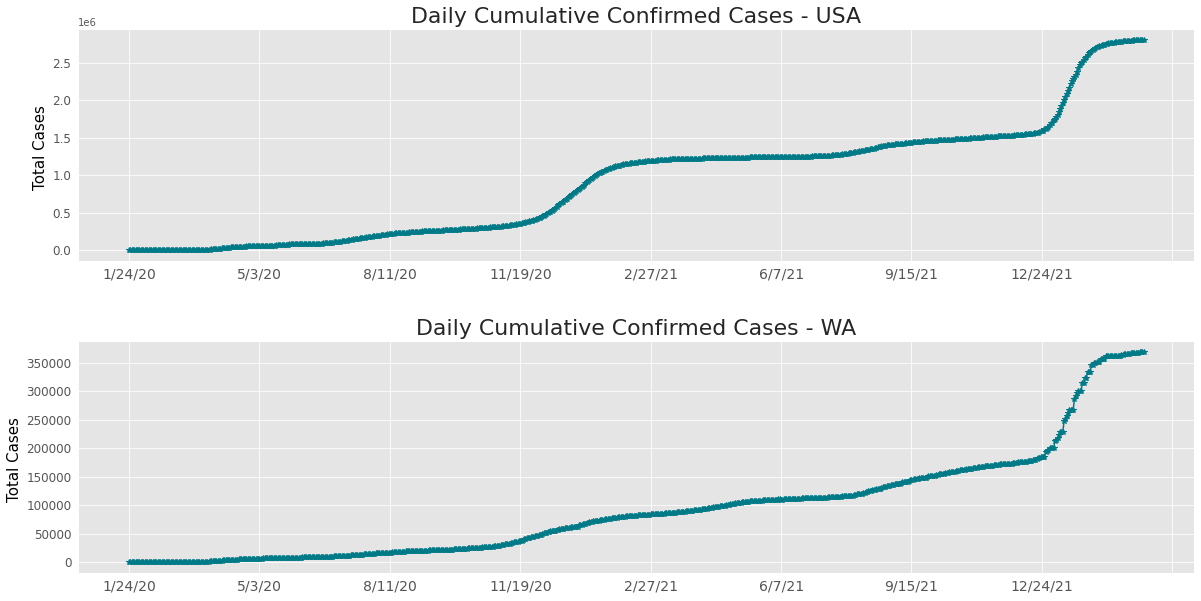

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 10))

plt.subplot(2, 1, 1)

confirmed_cases_us.iloc[:,13:].max().plot(marker='*' , color="#007A87" )
plt.title('Daily Cumulative Confirmed Cases - USA',fontdict={'fontsize': 22})
plt.ylabel('Total Cases ', fontsize='15', color = 'black')
ax.ticklabel_format(useOffset=False)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)



plt.subplot(2, 1, 2)

plt.subplots_adjust(hspace=0.35)
confirmed_cases_wa.iloc[:,13:].max().plot(marker='*', color="#007A87" )
plt.ylabel('Total Cases ', fontsize='15', color = 'black')
plt.title('Daily Cumulative Confirmed Cases - WA',fontdict={'fontsize': 22})
ax.ticklabel_format(useOffset=False)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)


We can observe the trends in the COVID-19 confirmed cases over the past 2 years in the WA state and US.

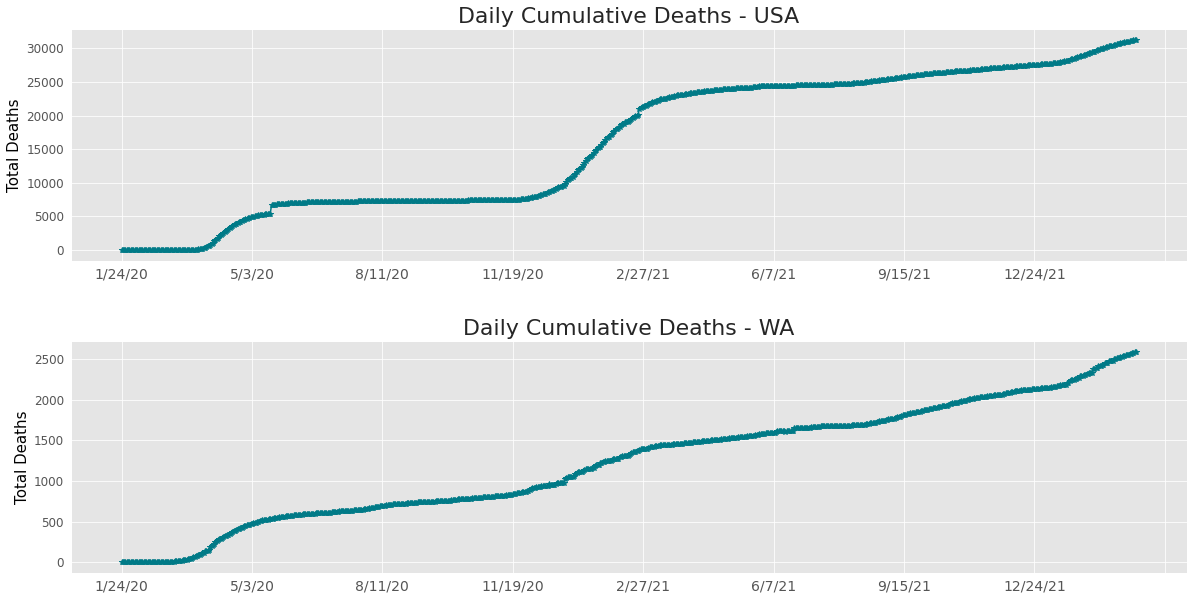

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (20, 10))


plt.subplot(2, 1, 1)

deaths_us.iloc[:,13:].max().plot(marker='*', color="#007A87")
plt.ylabel('Total Deaths', fontsize='15', color = 'black')
plt.title('Daily Cumulative Deaths - USA',fontdict={'fontsize': 22})
ax.ticklabel_format(useOffset=False)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)


          
plt.subplot(2, 1, 2)

plt.subplots_adjust(hspace=0.35)
deaths_wa.iloc[:,13:].max().plot(marker='*', color="#007A87"  )
plt.ylabel('Total Deaths', fontsize='15', color = 'black')
plt.title('Daily Cumulative Deaths - WA',fontdict={'fontsize': 22})
ax.ticklabel_format(useOffset=False)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)

We can observe the trends in the COVID-19 deaths over the past 2 years in the WA state and US.

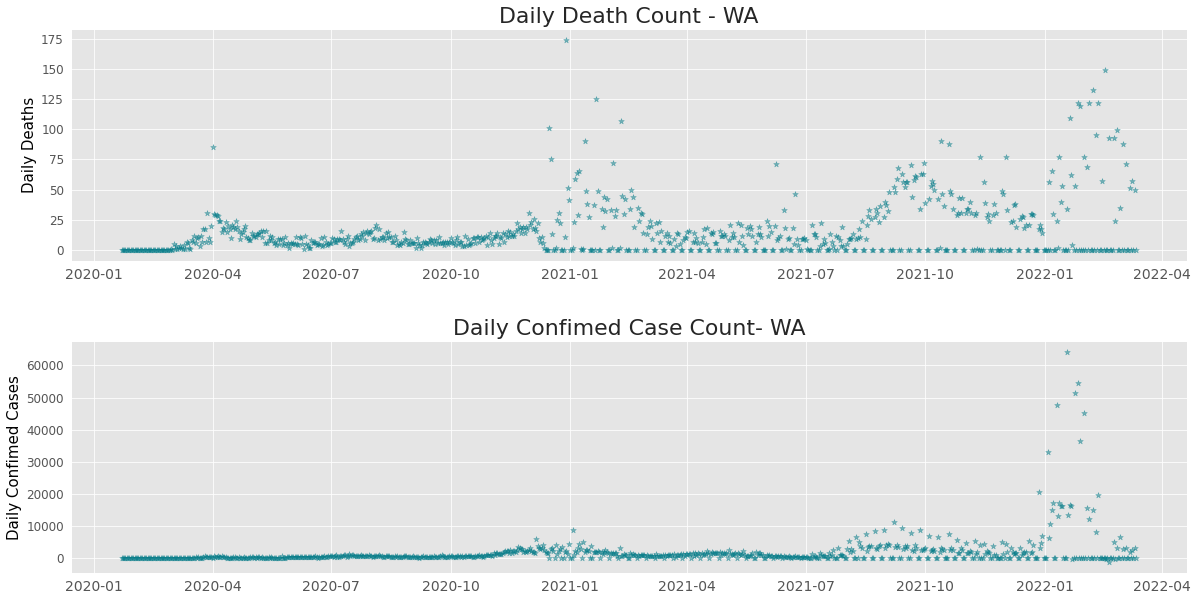

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (20, 10))


plt.subplot(2, 1, 1)

plt.scatter(wa_new['date'], wa_new['deaths_per_day'], alpha=0.5, marker='*', color="#007A87"  )
plt.ylabel('Daily Deaths', fontsize='15', color = 'black')
plt.title('Daily Death Count - WA',fontdict={'fontsize': 22})
ax.ticklabel_format(useOffset=False)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)


          
plt.subplot(2, 1, 2)

plt.subplots_adjust(hspace=0.35)
plt.scatter(wa_new['date'], wa_new['cases_per_day'], alpha=0.5, marker='*', color="#007A87"  )
plt.ylabel('Daily Confimed Cases', fontsize='15', color = 'black')
plt.title('Daily Confimed Case Count- WA',fontdict={'fontsize': 22})
ax.ticklabel_format(useOffset=False)
plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)



We could observe three peaks in the confirmed cases when we had our 1st , 2nd and 3rd COVID waves.

**Note:** While it could be misleading but a single date doesn't have more than one value for the deaths and confirmed cases. The graph is ploted in a way to show the time series over the two years, where the dates are closer to each other.

##Plot the Distribution of the Means

Text(0.5, 1.0, 'Mean Deaths - USA')

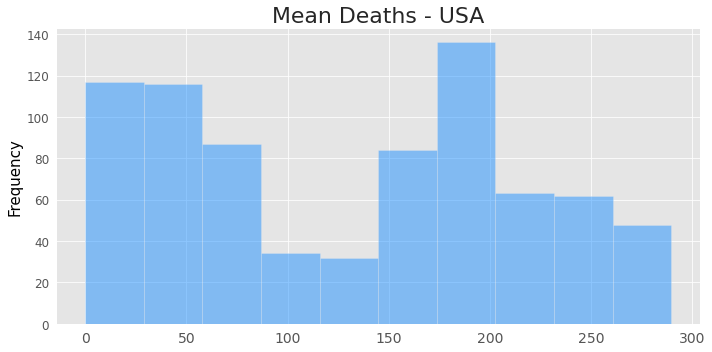

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5), tight_layout=True)
plt.hist(deaths_us.iloc[:,13:].mean() , color='dodgerblue', alpha = 0.5)

plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)

plt.ylabel('Frequency', fontsize='15', color = 'black')
plt.title('Mean Deaths - USA',fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Mean Confirmed Cases - USA')

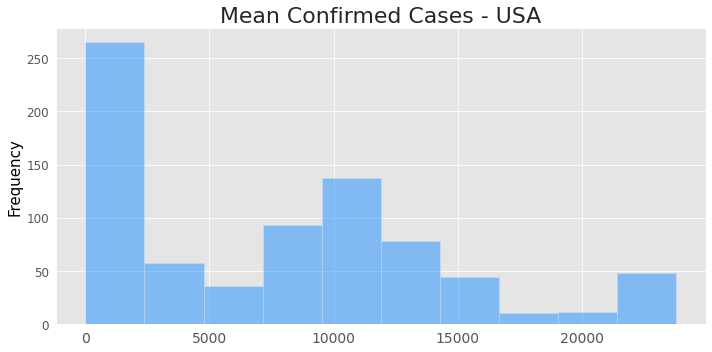

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5), tight_layout=True)
plt.hist(confirmed_cases_us.iloc[:,13:].mean() , color='dodgerblue', alpha = 0.5)

plt.xticks(fontsize=14)
plt.tick_params(axis='y', labelsize=12)

plt.ylabel('Frequency', fontsize='15', color = 'black')
plt.title('Mean Confirmed Cases - USA',fontdict={'fontsize': 22})

These distributions might not provide any extra information but it is often recommended to look at the distribution of the data to be analysed.

#Model

## Research

We came across the paper - *Integration of Kalman filter in the epidemiological model: a robust approach to predict COVID-19 outbreak in Bangladesh*.https://www.medrxiv.org/content/10.1101/2020.10.14.20212878v2.full

\\

It used the standard SIRD model to estimate the number of COVID-19 active cases, recovered cases, and death cases. It involved segmentation of the total population size, **N**, into four stages of the disease: **S**, susceptible; **I**, infected; **R**, recovered; **D**, death and can be written by \
**N = S + I + R + D**.

\\

The population, **N = S(t) + I(t) + R(t) + D(t)**, is a conserved quantity for every time step, where t denotes the time duration.

\\

$$\mathbf{S}_{t+1} = (1-βI{_t} \Delta t/N)$$
$$\mathbf{I}_{t+1} = (1-\gamma\Delta t + βS{_t}\Delta t/N)I{_t} - μD{_t}\Delta t$$
$$\mathbf{R}_{t+1} = \gamma I{_t}\Delta t$$
$$\mathbf{D}_{t+1} = \mu I{_t}\Delta t$$

\\

An augmented state vector X is presented for simplicity as

$$\mathbf{X} = \begin{bmatrix}S{_t} \\ I{_t}\\ R{_t}\\ D{_t}\end{bmatrix}$$

\\

and the discrete-time augmented SIRD model can be written as

\\

$$\mathbf{X}_{t+1} = F(X{_t}) + W{_t}$$

\\

where F is the nonlinear term and W is the zero mean Gaussian uncertainty with covariance Qf. All types of reported cases, the cumulative confirmed, recovered, deaths and active cases, are incorporated with the model using the vector as

\\

$$\mathbf{Y}_{t+1} = CX{_t} + v{_t}$$

\\

where ν is the uncertainties due to the SERS-CoV-2 test results. The considered zero mean Gaussian uncertainty has the known covariance Rf.

\\

Predict and Update equation for this model are as given below:

\\

**Predict**
$$\mathbf{X}(t+1|t) = F(\hat X({t|t}))$$
$$\mathbf{P}(t+1|t) = J{_F}\hat X(t|t)P({t|t})J{_F}(\hat X(t|t))^T + Q{_F}(t)$$

**Update**
$$\mathbf{\hat Y}(t+1|t) = Y(t+1) - C \hat X (t+1|t)$$
$$\mathbf{K(t+1)} = P(t+1|t)C^T(CP({t+1|t})C^T + R{_F}(t))^{-1}$$
$$\mathbf{\hat X}(t+1|t+1) = \hat X({t+1|t}) + K(t+1) \hat Y(t+1)$$
$$\mathbf{P}(t+1|t+1) = (I - K(t+1)C P(t+1|t) )$$


\\

Here, P (t |t) and C represent the posterior estimate covariance matrix and the data augmented matrix respectively. But considering all the variables which are included in the state will make the model very complex. Therefore, we have come up with a below simpler model and predicted the Covid-19 cases for the next 15 days.




##Kalman Filter

Consider a discrete-time $n$-dimensional linear dynamic system with state $\mathbf{x}_k$ at time $k$ and observation $\mathbf{y}_k$ at time $k$ that obey the following equations

$$\mathbf{x}_{k+1} = A_k\mathbf{x}_{k} + B_k\mathbf{u}_k + \mathbf{w}_k$$
$$\mathbf{y}_k = C_k\mathbf{x}_k + \mathbf{v}_k$$


 
The filtering problem is to recursively estimate the state $\mathbf{x}_k$ given the sequence of measurements up to time $k$: $\mathcal{Y}_k = \{\mathbf{y}_0, \mathbf{y}_1, \ldots, \mathbf{y}_k\}$.

\\


The prediction problem is to estimate the state $\mathbf{x}_{k + j}$, where $j \geq 1$, at some time beyond the current measurement $\mathcal{Y}_k = \{\mathbf{y}_0, \mathbf{y}_1, \ldots, \mathbf{y}_k\}$.


\\


The form of the Kalman filter, predictor, and smoother depend some assumptions about the conditions of optimality. We can view the problem in one of two ways:

1. We do not make assumptions about the distributions of the noise disturbances, but we limit ourselves to finding the minimum mean-square **linear** estimator.

2. Or, we assume that the noise disturbances have normal distributions and we find the minimum mean-square estimator. Here we do not need to assume that the estimator is linear because the minimum mean-square estimator is linear in this case.

The state $\mathbf{x}_k$ in this problem could be taken as $cases_k$ and $ cases'_k$

$$\mathbf{x}_k = \begin{bmatrix}cases_k \\ cases'_k\end{bmatrix}$$


\begin{align}
cs(t + \Delta t) &= cs(t) + \Delta tcs'(t) + \text{error}
\end{align}

\\

\begin{align}
cs'(t + \Delta t) &= cs'(t) + \Delta tcs''(t) + \text{error}  \\ \\
&= cs'(t) + \text{error}
\end{align}

\\

We will assume here that there is no control signal.

\\



$$\mathbf{x}_{k+1} = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}\mathbf{x}_{k} + \begin{bmatrix}0\\ 0\end{bmatrix}u_{k} + \mathbf{w}_k$$

$\mathbf{w}_k$ is a noise term.

\\

The observation equation depends on what we assume that we can measure. If we assume that we can only measure a noisy version of the cases, then the observation equation would be 

$$y_k = \begin{bmatrix}1 & 0\end{bmatrix}\mathbf{x}_{k} + \mathbf{v}_k$$
where $\mathbf{v}_k$ is a noise term.

\\

In this model, the matrices are constant and given by:

$$A = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}$$

\\

$$B = \begin{bmatrix}0\\ 0\end{bmatrix}$$

\\

$$C = \begin{bmatrix}1 & 0\end{bmatrix}$$

The noise terms are typically assumed to be independent across components. You can make reasonable guesses for the covariances and refine the guesses by fitting the parameters using observed data.

\\

#### Time

Specify the parameters describing time in the simulation.

In [ ]:
#Time step
dt = 1

#Number of time steps
n_timesteps = len(wa_new['date'])

#Time
t = np.arange(n_timesteps)*dt

#### Matrices

Define the matrices $A$, $B$, and $C$.

In [ ]:
A = np.array([[1, dt],
             [0, 1]])

B = np.array([[0],[0]])

C = np.array([[1, 0]])

#Use these matrices to determine the dimensions of the state and observation vectors
n_dim_state = A.shape[0]

n_dim_obs = C.shape[0]

### Control signal

Unsure about the control signal $u_k$ in this example so we will assume that the it is constant.

In [ ]:
u = np.ones((1,n_timesteps))

The `pykalman` code uses the notation $b_k = B_ku_k$, so we compute this for use in their code.

In [ ]:
b = np.matmul(B,u)

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [ ]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[4.0, 0.0], [0.0, 1.0]]


Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [ ]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 8


### Use the Kalman filter to estimate the states

Specify your observation

In [ ]:
y = wa_new['cases_per_day']

Define a Kalman filter object with the known properties of the system

In [ ]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [ ]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

([<matplotlib.axis.XTick at 0x7f4e2f442c50>,
 [Text(0, 0, '01-23-2020'),
  Text(0, 0, '05-02-2020'),
  Text(0, 0, '08-10-2020'),
  Text(0, 0, '11-18-2020'),
  Text(0, 0, '02-26-2021'),
  Text(0, 0, '06-06-2021'),
  Text(0, 0, '09-14-2021'),
  Text(0, 0, '12-23-2021'),
  Text(0, 0, '04-02-2022')])

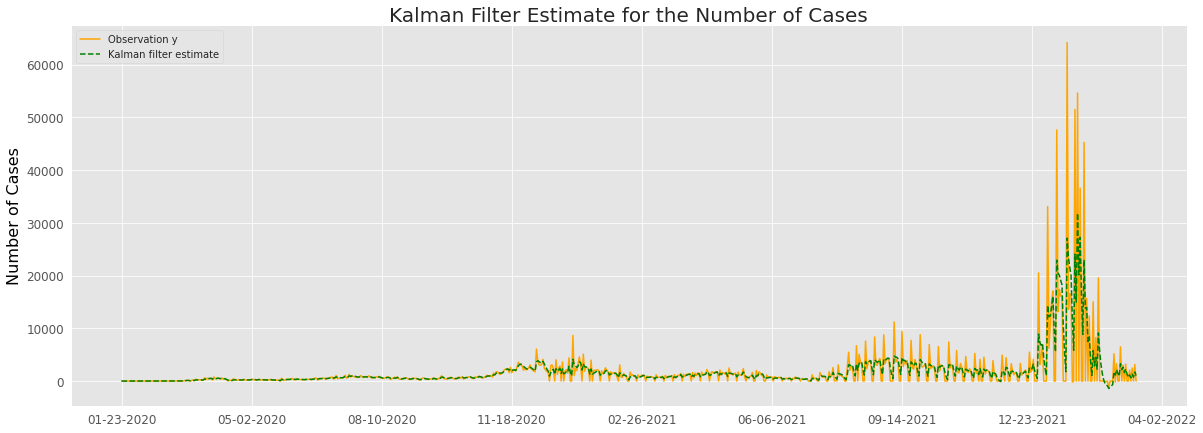

In [ ]:
# Set figure size
plt.figure(figsize = (20,7))

#Plot confirmed cases
plt.plot(t,y, 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

# Set title, lables and legend
plt.ylabel('Number of Cases', fontsize='16', color = 'black')
plt.legend(['Observation y', 'Kalman filter estimate'])
plt.title('Kalman Filter Estimate for the Number of Cases',  pad='4.0' , fontsize='20')

# set the size of the tick parameters
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

# Make the x lables display actuals dates instead of numbers
x = [0, 100, 200, 300, 400, 500, 600, 700, 800]
labels = ['01-23-2020','05-02-2020', '08-10-2020', '11-18-2020','02-26-2021','06-06-2021','09-14-2021','12-23-2021', '04-02-2022']
plt.xticks(x,labels)


The Kalman filter does a decent job of estimating the number of cases. Lets further look at the difference of the Kalman filter estimates and the observed confirmed daily cases.

([<matplotlib.axis.XTick at 0x7f4e2f3d46d0>,
 [Text(0, 0, '01-23-2020'),
  Text(0, 0, '05-02-2020'),
  Text(0, 0, '08-10-2020'),
  Text(0, 0, '11-18-2020'),
  Text(0, 0, '02-26-2021'),
  Text(0, 0, '06-06-2021'),
  Text(0, 0, '09-14-2021'),
  Text(0, 0, '12-23-2021'),
  Text(0, 0, '04-02-2022')])

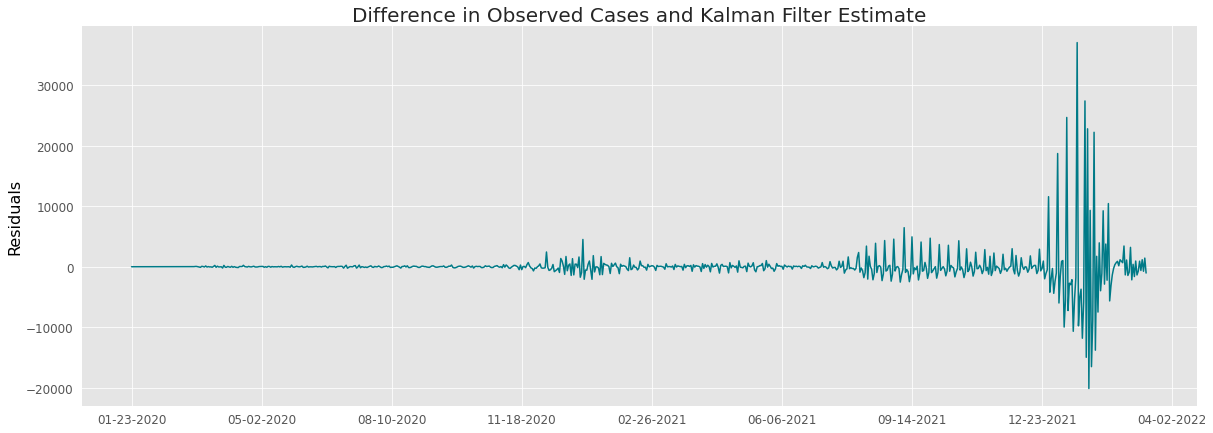

In [ ]:
#Plot difference of observed and Kalman estimate
plt.figure(figsize = (20,7))
plt.plot(t,y - filtered_state_means[:,0],color = '#007A87')

plt.title('Difference in Observed Cases and Kalman Filter Estimate',  pad='4.0' , fontsize='20')
plt.ylabel('Residuals', fontsize='16', color = 'black')

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

x = [0, 100, 200, 300, 400, 500, 600, 700, 800]
labels = ['01-23-2020','05-02-2020', '08-10-2020', '11-18-2020','02-26-2021','06-06-2021','09-14-2021','12-23-2021', '04-02-2022']
plt.xticks(x,labels)

We observe that the greater variation is when we were hit by the omnicron variant.

### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [ ]:
state_cov_matrix_guess = [[1.0, 0.], [0., 1.0]]

obs_std_guess = 1.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [ ]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [ ]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [ ]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[1150271.42461628 -282531.27367982]
 [-282531.27367982  290103.68557485]] . True covariance =  [[4.0, 0.0], [0.0, 1.0]]


In [ ]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[18392585.13401716]] . True variance =  64


Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [ ]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [ ]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)

### Use the Kalman filter to estimate the states

Define a Kalman filter object with the known properties of the system

In [ ]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [ ]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

([<matplotlib.axis.XTick at 0x7f4e2f2ee310>,
 [Text(0, 0, '01-23-2020'),
  Text(0, 0, '05-02-2020'),
  Text(0, 0, '08-10-2020'),
  Text(0, 0, '11-18-2020'),
  Text(0, 0, '02-26-2021'),
  Text(0, 0, '06-06-2021'),
  Text(0, 0, '09-14-2021'),
  Text(0, 0, '12-23-2021'),
  Text(0, 0, '04-02-2022')])

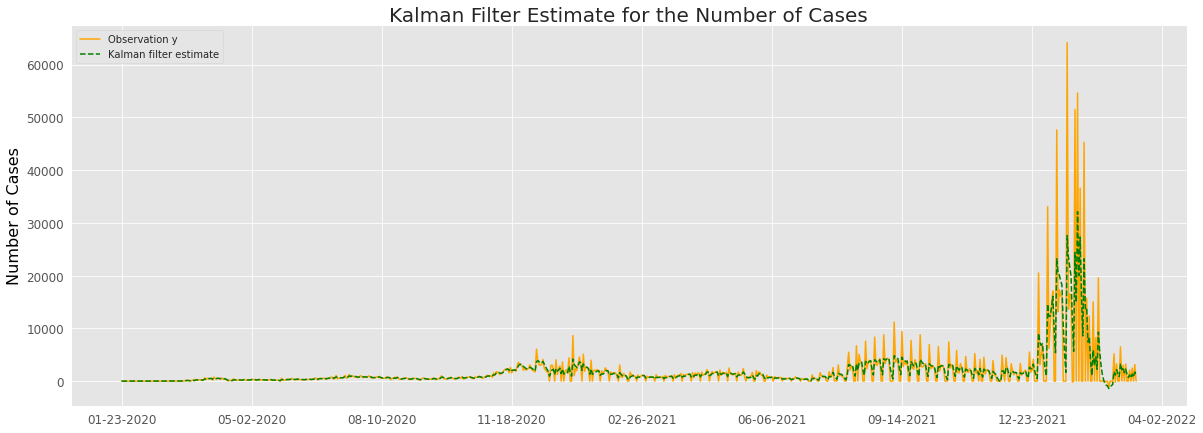

In [ ]:

plt.figure(figsize = (20,7))

#Plot confirmed cases

plt.plot(t,y, 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.ylabel('Number of Cases', fontsize='16', color = 'black')
plt.legend(['Observation y', 'Kalman filter estimate'])
plt.title('Kalman Filter Estimate for the Number of Cases',  pad='4.0' , fontsize='20')

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

x = [0, 100, 200, 300, 400, 500, 600, 700, 800]
labels = ['01-23-2020','05-02-2020', '08-10-2020', '11-18-2020','02-26-2021','06-06-2021','09-14-2021','12-23-2021', '04-02-2022']
plt.xticks(x,labels)


The Kalman filter does a great job of estimating the number of cases making use of the EM algorithm to estimate unknown model parameters. We'd further want to have a better look towards the end of the graph.

([<matplotlib.axis.XTick at 0x7f4e2f2b8290>,
 [Text(0, 0, '12-23-2021'),
  Text(0, 0, '01-12-2022'),
  Text(0, 0, '02-01-2022'),
  Text(0, 0, '02-21-2022'),
  Text(0, 0, '03-13-2022'),
  Text(0, 0, '04-02-2022')])

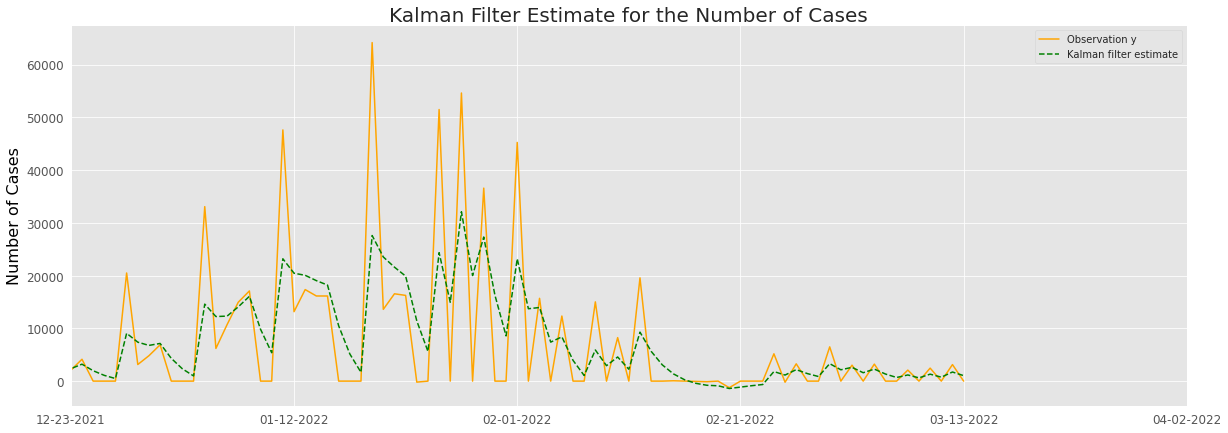

In [ ]:

plt.figure(figsize = (20,7))

#Plot confirmed cases

plt.plot(t,y, 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

#plt.xlabel('Time (In Days)', fontsize='15', color = 'black')
plt.ylabel('Number of Cases', fontsize='16', color = 'black')
plt.legend(['Observation y', 'Kalman filter estimate'])
plt.title('Kalman Filter Estimate for the Number of Cases',  pad='4.0' , fontsize='20')

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlim([700, 800])

x = [700, 720 , 740, 760, 780 ,800]
labels = ['12-23-2021','01-12-2022', '02-01-2022', '02-21-2022' , '03-13-2022', '04-02-2022']
plt.xticks(x,labels)

The Kalman filter does an excellent job in estimating the numbers closer to the observed cases. Lets examine the difference of the Kalman filter estimates and the observed confirmed daily cases.

([<matplotlib.axis.XTick at 0x7f4e2f241350>,
 [Text(0, 0, '01-23-2020'),
  Text(0, 0, '05-02-2020'),
  Text(0, 0, '08-10-2020'),
  Text(0, 0, '11-18-2020'),
  Text(0, 0, '02-26-2021'),
  Text(0, 0, '06-06-2021'),
  Text(0, 0, '09-14-2021'),
  Text(0, 0, '12-23-2021'),
  Text(0, 0, '04-02-2022')])

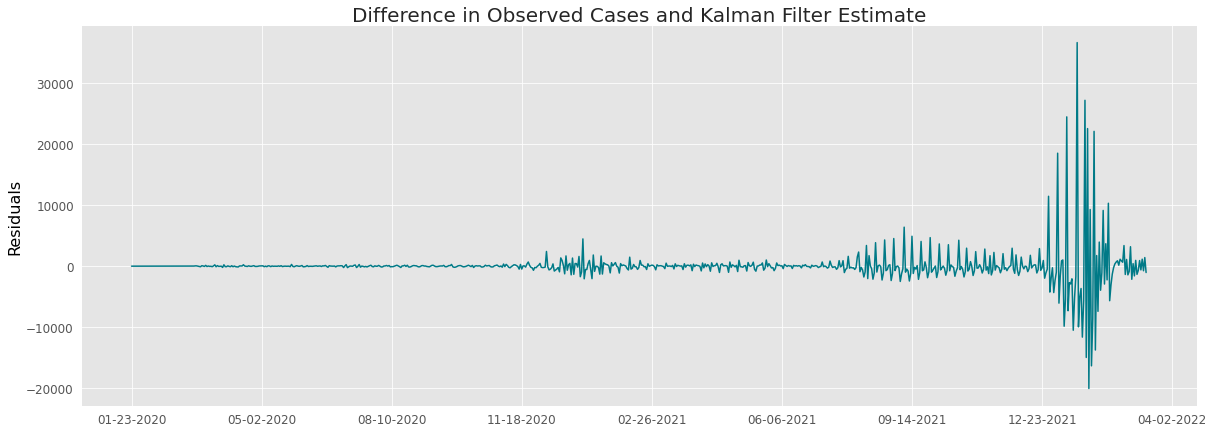

In [ ]:
#Plot the difference
plt.figure(figsize = (20,7))
plt.plot(t,y - filtered_state_means[:,0],color = '#007A87')
plt.title('Difference in Observed Cases and Kalman Filter Estimate',  pad='4.0' , fontsize='20')
#plt.xlabel('Time (In Days)', fontsize='16', color = 'black')
plt.ylabel('Residuals', fontsize='16', color = 'black')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

x = [0, 100, 200, 300, 400, 500, 600, 700, 800]
labels = ['01-23-2020','05-02-2020', '08-10-2020', '11-18-2020','02-26-2021','06-06-2021','09-14-2021','12-23-2021', '04-02-2022']
plt.xticks(x,labels)

Lets take a better look towards the end of the graph.

([<matplotlib.axis.XTick at 0x7f4e2f1b0d90>,
 [Text(0, 0, '12-23-2021'),
  Text(0, 0, '01-12-2022'),
  Text(0, 0, '02-01-2022'),
  Text(0, 0, '02-21-2022'),
  Text(0, 0, '03-13-2022'),
  Text(0, 0, '04-02-2022')])

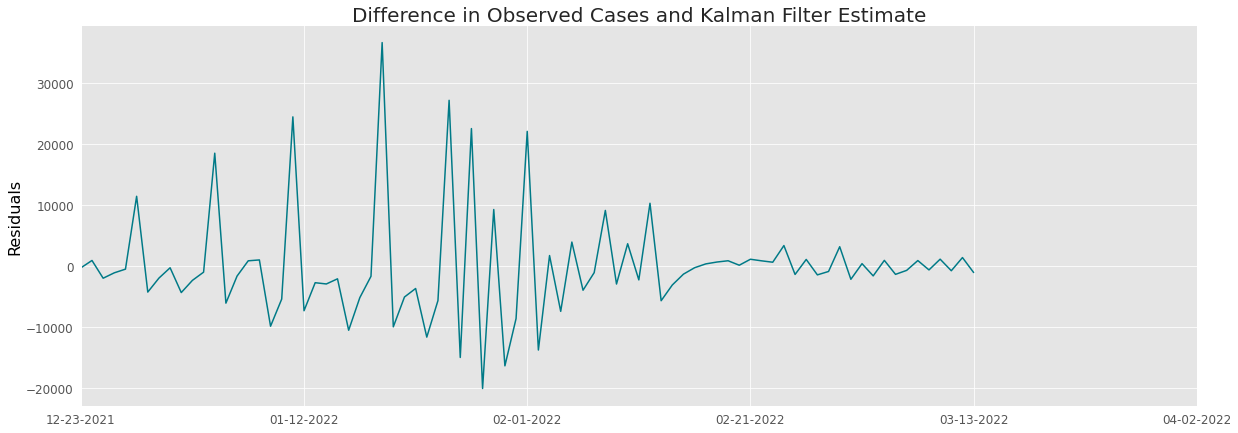

In [ ]:
#Plot the difference
plt.figure(figsize = (20,7))
plt.plot(t,y - filtered_state_means[:,0],color = '#007A87')
plt.title('Difference in Observed Cases and Kalman Filter Estimate',  pad='4.0' , fontsize='20')
#plt.xlabel('Time (In Days)', fontsize='16', color = 'black')
plt.ylabel('Residuals', fontsize='16', color = 'black')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlim([700, 800])

x = [700, 720 , 740, 760, 780 ,800]
labels = ['12-23-2021','01-12-2022', '02-01-2022', '02-21-2022' , '03-13-2022', '04-02-2022']
plt.xticks(x,labels)


The Kalman filter shows greater variation in eastimates during the time of 3rd COVID wave but as soon it learns from the data, the variations gets reduced.

#Predict

We are going to run a for loop on the Kalman equation to get the prediction for the next 15 days.

In [ ]:
for n in range(15):
  x_prev = filtered_state_means[-1]
  x_next = np.matmul(A,x_prev) + b.T[-1]

  filtered_state_means = np.vstack((filtered_state_means, x_next))

([<matplotlib.axis.XTick at 0x7f4e2f24b090>,
 [Text(0, 0, '01-02-2022'),
  Text(0, 0, '02-11-2022'),
  Text(0, 0, '02-21-2022'),
  Text(0, 0, '03-03-2022'),
  Text(0, 0, '03-13-2022'),
  Text(0, 0, '03-23-2022'),
  Text(0, 0, '04-02-2022')])

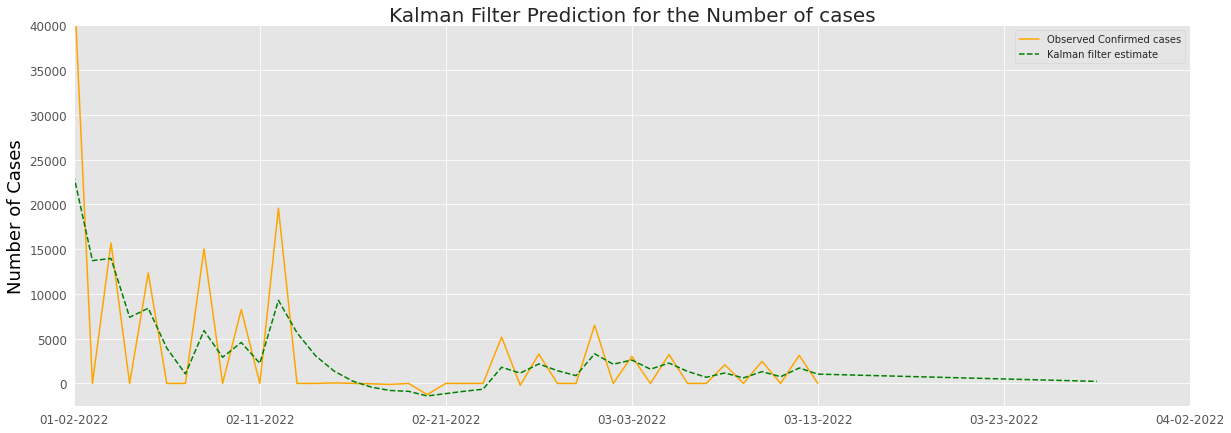

In [ ]:
plt.figure(figsize = (20,7))

# variable to store the 15 more days than the existing data.
t_15 = np.arange(n_timesteps + 15)*dt

#Plot confirmed cases

plt.plot(t,y, 'orange')
plt.plot(t_15,filtered_state_means[:,0], 'g--')

# Set the labels, legends and title
plt.ylabel('Number of Cases', fontsize='18', color = 'black')
plt.legend(['Observed Confirmed cases', 'Kalman filter estimate'])
plt.title('Kalman Filter Prediction for the Number of cases',  pad='4.0' , fontsize='20')

# set x and y tick sizes
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

# Play with limits to show the recent plot
plt.xlim([740, 800])
plt.ylim([-2500, 40000])

# show dates instead of numbers
x = [740, 750, 760, 770 , 780, 790 ,800]
labels = ['01-02-2022','02-11-2022' , '02-21-2022' , '03-03-2022' , '03-13-2022', '03-23-2022', '04-02-2022']
plt.xticks(x,labels)

The Kalman filter quickly predicts the confirmed daily cases for the next 15 days, with the obvious drop in the numbers.

**Note:** We observe negative curve in the above plot which is due to data issues which should be reported to help fix the data quality.

#Final Verdict

The Kalman Filter did a great job at predicting COVID-19 cases for the Washington State. Here we conisered a simple model with no control inputs, which restricted us to make a prediction for a large number of days in the future. However, a good epidemiological model could result in better prediciton of cases. Correcting data qualilty from the source can be viewed as an improvement for the near future.